# Hypothesis

Quantum Convolutional Neural Networks built on Quantum Circuit Born Machines using Layerwise Learning techniques offer a superior approach to dealing with errors on NISQ devices than that of Quantum CNN, Hybrid CNN or Layerwise Learning approaches alone.

# Approach

In Phase I, we start training with a small number of convolutional & pooling layers and train those for a fixed number of epochs. After that, in Phase II we add another set of layers and freeze the parameters of the previous step's layers. We repeat this process until the desired depth is reached. 

In phase II, we perform additional optimization sweeps over larger subsets of the layers using the final circuit configuration from phase one. The parameters from this circuit give us a good starting point to optimize quarters, halves, or even the full circuit without initializing on a barren plateau.

Phase III makes final adjustments to partition %s and sweeps.

This kind of learning scheme can be used for various types of learning tasks and input data, so long as the QCNN structure allows iteratively building the circuits. In this notebook we look at a simple example of classifying Cluster State excitations.

[1] Layerwise learning for quantum neural networks, A. Skolik, J. R. McClean, M. Mohseni, P. van der Smagt, and M. Leib, https://arxiv.org/pdf/2006.14904.pdf

[2] Barren plateaus in quantum neural network training landscapes, J. R. McClean, S. Boixo, V. N. Smelyanskiy, R. Babbush, and H. Neven, Nature Communications 9 (2018) https://www.nature.com/articles/s41467-018-07090-4.pdf

# Setup

In [1]:
!pip install --upgrade tensorflow==2.7.0

     |████████████████████████████████| 489.6 MB 17 kB/s 
     |████████████████████████████████| 1.3 MB 56.8 MB/s 
     |████████████████████████████████| 463 kB 63.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0


In [1]:
!pip install tensorflow-quantum

In [2]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [3]:
import collections
import itertools
import random
import copy

import cirq
import sympy
import numpy as np
import tensorflow_quantum as tfq
import tensorflow as tf

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# Data

In [4]:
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]
    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [5]:
# Generates sample data on the specified qubit in the simulated quantum computing processor( e.g. Bristlecone, Sycamore)
sample_points, sample_labels, _, __ = generate_data(cirq.GridQubit.rect(1, 4))
print('Input:', tfq.from_tensor(sample_points)[0], 'Output:', sample_labels[0])
print('Input:', tfq.from_tensor(sample_points)[1], 'Output:', sample_labels[1])

Input: (0, 0): ───X^0.225─── Output: 1
Input: (0, 1): ───X^0.295─── Output: 1


# Layer Generation

## Circuit Layers Generation

In [6]:
def create_layer(qubits, layer_id):
    symbols = [sympy.Symbol(layer_id + '-' + str(i)) for i in range(len(qubits))]
    gate_set = [cirq.rx, cirq.ry, cirq.rz]

    gates = []
    symbol_gates = []
    for i, q in enumerate(qubits):
        chosen_gate = random.choice(gate_set)
        gates.append(chosen_gate(0)(q))
        symbol_gates.append(chosen_gate(symbols[i])(q))

    for control, target in zip(qubits, qubits[1:]):
        gates.append(cirq.CZ(control, target))
        symbol_gates.append(cirq.CZ(control, target))

    return gates, symbol_gates, symbols

## Define Layers

### The Cluster State

In [7]:
def cluster_state_circuit(qubits):
    """Return a cluster state on the qubits in `qubits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(qubits))
    for this_bit, next_bit in zip(qubits, qubits[1:] + [qubits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


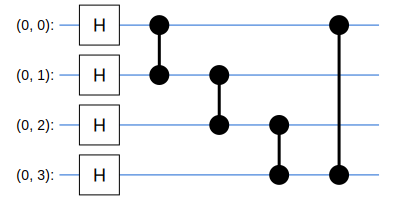

In [8]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

### QCNN Layers

#### Single Qubit Unitary Circuit

In [9]:
def one_qubit_unitary(qubit):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis.
    """
    return cirq.Circuit(
        cirq.X(qubit),
        cirq.Y(qubit),
        cirq.Z(qubit))

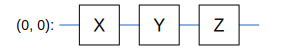

In [10]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0)))

#### Two Qubit Unitary Circuit

In [11]:
def two_qubit_unitary(qubits):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(qubits[0])
    circuit += one_qubit_unitary(qubits[1])
    circuit += [cirq.ZZ(*qubits)]
    circuit += [cirq.YY(*qubits)]
    circuit += [cirq.XX(*qubits)]
    circuit += one_qubit_unitary(qubits[0])
    circuit += one_qubit_unitary(qubits[1])
    return circuit

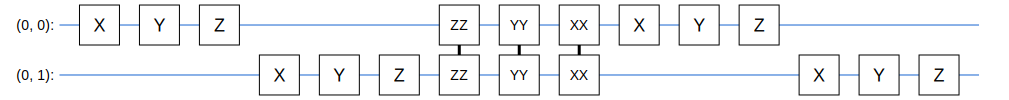

In [12]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2)))

#### Two Qubit Pooling Circuit

In [13]:
def two_qubit_pool(source_qubit, sink_qubit):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit)
    source_basis_selector = one_qubit_unitary(source_qubit)
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

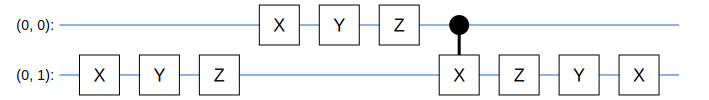

In [14]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2)))

#### 1D Quantum Convolution

As in the [Cong and Lukin paper](https://arxiv.org/abs/1810.03787), define the 1D quantum convolution as the application of a two-qubit parameterized unitary to every pair of adjacent qubits with a stride of one.

In [15]:
def quantum_conv_circuit(qubits):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(qubits[0::2], qubits[1::2]):
        circuit += two_qubit_unitary([first, second])
    for first, second in zip(qubits[1::2], qubits[2::2] + [qubits[0]]):
        circuit += two_qubit_unitary([first, second])
    return circuit

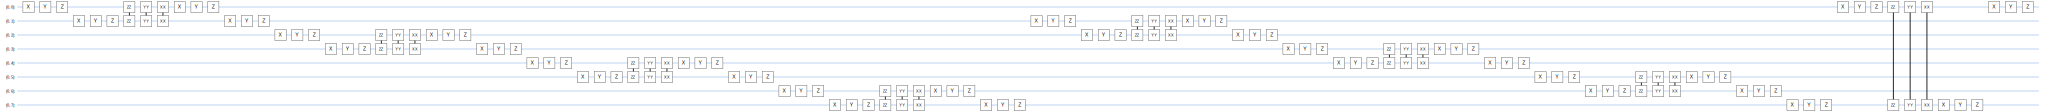

In [16]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 8)))

#### Quantum Pooling


A quantum pooling layer pools from $N$ qubits to $\frac{N}{2}$ qubits using the two-qubit pool defined above.

In [17]:
def quantum_pool_circuit(source_qubits, sink_qubits):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_qubits, sink_qubits):
        circuit += two_qubit_pool(source, sink)
    return circuit

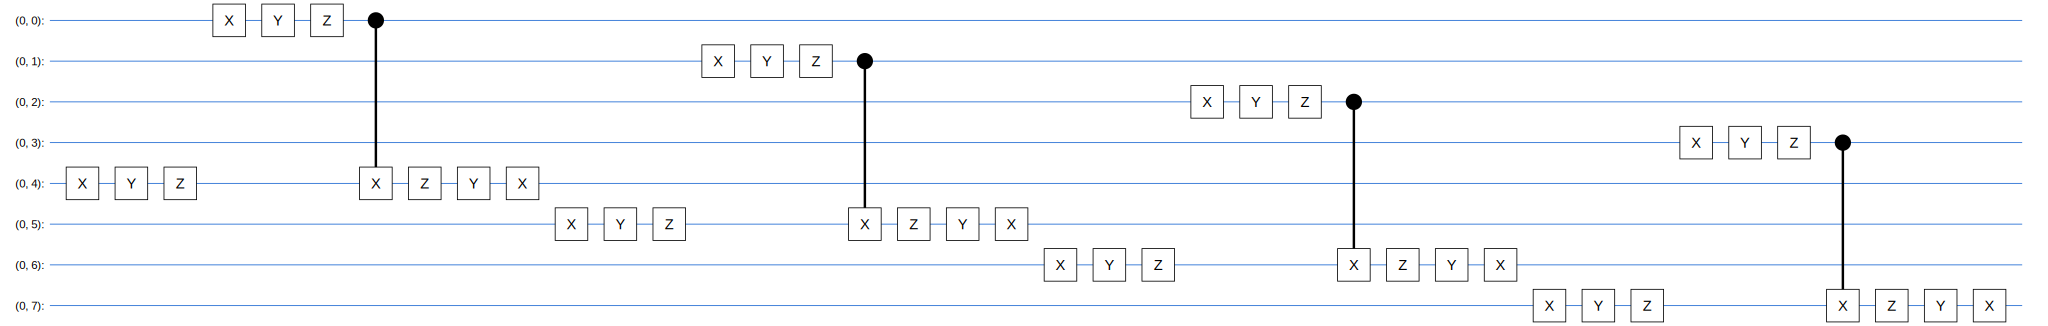

In [18]:
test_qubits = cirq.GridQubit.rect(1, 8)

SVGCircuit(
    quantum_pool_circuit(test_qubits[:4], test_qubits[4:]))

# Baseline Models

## Quantum Classical Hybrid
Quantum convolution that feeds the results into a classical neural network.

Hybrid model with a single quantum filter.
Applies one layer of quantum convolution, reading out on all bits, followed by a densely-connected neural network.

In [19]:
n_qubits = 8
n_layer_steps = 5
n_layers_to_add = 2
''' data_qubits = cirq.GridQubit.rect(1, n_qubits) '''
''' readout = cirq.GridQubit(0, n_qubits-1) '''
# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, n_qubits)
readout_operators = cirq.Z(cluster_state_bits[-1])

symbols = []
layers = []
symbol_layers = []
weights = []

acc_hybrid = []
val_acc_hybrid = []
loss_hybrid = []
val_loss_hybrid = []

training_history = []

# Generate some training data.
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)

# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    #remove dimensions of size 1 from the shape of the tensor
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

for layer_id in range(n_layer_steps):
  print("\nLayer:", layer_id)
  #Create sequence of alternating convolution and pooling operators which gradually shrink over time.
  circuit = cirq.Circuit()
  for i in range(n_layers_to_add):
    layer, symbol_layer, layer_symbols = create_layer(cluster_state_bits, f'layer_{layer_id}_{i}')
    layers.append(layer)
    symbol_layers.append(symbol_layer)
    symbols.append(layer_symbols)
    
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    circuit += quantum_conv_circuit(cluster_state_bits)
    circuit += quantum_pool_circuit(cluster_state_bits[:4], cluster_state_bits[4:])
      
  circuit += symbol_layers

  # setup the Keras model
  excitation_input_dual = tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string)
  cluster_state_dual = tfq.layers.AddCircuit()(
      excitation_input_dual, prepend=cluster_state_circuit(cluster_state_bits))
  quantum_model_dual = tfq.layers.PQC(
      model_circuit=circuit, operators=readout_operators)(cluster_state_dual)

  d1_dual = tf.keras.layers.Dense(n_qubits)(quantum_model_dual)

  d2_dual = tf.keras.layers.Dense(1)(d1_dual)

  hybrid_model = tf.keras.Model(inputs=[excitation_input_dual], outputs=[d2_dual])

  print(hybrid_model.summary())
  #Uses Squared Hinge max margin cost function to penalize misclassification and 
  #classify those correct ones residing within margin of the decision boundary
  hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                       loss=tf.losses.mse,
                       metrics=[custom_accuracy])


  hybrid_model_history = hybrid_model.fit(
      x=train_excitations,
      y=train_labels,
      batch_size=128,
      epochs=25,
      verbose=1,
      validation_data=(test_excitations, test_labels))

  acc_hybrid += hybrid_model_history.history['custom_accuracy']
  val_acc_hybrid += hybrid_model_history.history['val_custom_accuracy']
  loss_hybrid += hybrid_model_history.history['loss']
  val_loss_hybrid += hybrid_model_history.history['val_loss']

  weights = hybrid_model.get_weights()[0]


Layer: 0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 add_circuit (AddCircuit)    (None,)                   0         
                                                                 
 pqc (PQC)                   (None, 1)                 16        
                                                                 
 dense (Dense)               (None, 8)                 16        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
1/1 [==============================] - 

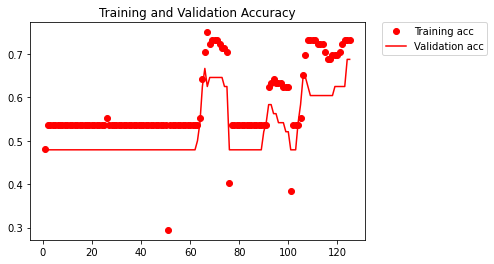

In [20]:
epochs_hybrid = range(1, len(acc_hybrid) + 1)

plt.plot(epochs_hybrid, acc_hybrid, 'o', color='red', label='Training acc')
plt.plot(epochs_hybrid, val_acc_hybrid, color='red', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

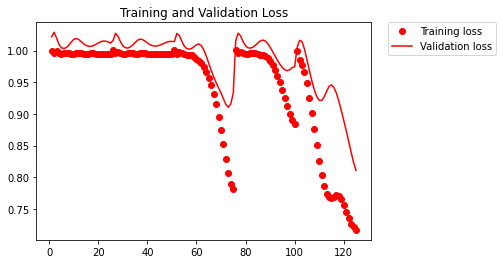

In [21]:
plt.plot(epochs_hybrid, loss_hybrid, 'o', color='red', label='Training loss')
plt.plot(epochs_hybrid, val_loss_hybrid, color='red', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

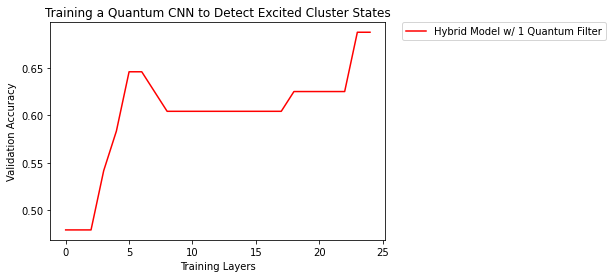

In [22]:
plt.plot(hybrid_model_history.history['val_custom_accuracy'], color='red', label='Hybrid Model w/ 1 Quantum Filter')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Training Layers')
plt.ylabel('Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Hybrid convolution with multiple quantum filters

A hybrid architecture that uses multiple quantum convolutions and a classical neural network to combine them.

In [23]:
n_qubits = 8
n_layer_steps = 5
n_layers_to_add = 2
''' data_qubits = cirq.GridQubit.rect(1, n_qubits) '''
''' readout = cirq.GridQubit(0, n_qubits-1) '''
# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, n_qubits)
readout_operators = cirq.Z(cluster_state_bits[-1])

symbols = []
layers = []
symbol_layers = []
weights = []

acc_hybrid_multi = []
val_acc_hybrid_multi = []
loss_hybrid_multi = []
val_loss_hybrid_multi = []

training_history = []

# Generate some training data.
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)

# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    #remove dimensions of size 1 from the shape of the tensor
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

for layer_id in range(n_layer_steps):
  print("\nLayer:", layer_id)
  #Create sequence of alternating convolution and pooling operators which gradually shrink over time.
  circuit = cirq.Circuit()
  for i in range(n_layers_to_add):
    layer, symbol_layer, layer_symbols = create_layer(cluster_state_bits, f'layer_{layer_id}_{i}')
    layers.append(layer)
    symbol_layers.append(symbol_layer)
    symbols.append(layer_symbols)
    
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    circuit += quantum_conv_circuit(cluster_state_bits)
    circuit += quantum_pool_circuit(cluster_state_bits[:4], cluster_state_bits[4:])
      
  circuit += symbol_layers

  # setup the Keras model
  excitation_input_multi = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
  cluster_state_multi = tfq.layers.AddCircuit()(
      excitation_input_multi, prepend=cluster_state_circuit(cluster_state_bits))
  quantum_model_multi1 = tfq.layers.PQC(
      model_circuit=circuit, operators=readout_operators)(cluster_state_multi)
  quantum_model_multi2 = tfq.layers.PQC(
      model_circuit=circuit, operators=readout_operators)(cluster_state_multi)
  quantum_model_multi3 = tfq.layers.PQC(
      model_circuit=circuit, operators=readout_operators)(cluster_state_multi)

  # concatenate outputs and feed into a small classical NN
  concat_out = tf.keras.layers.concatenate(
      [quantum_model_multi1, quantum_model_multi2, quantum_model_multi3])

  dense_1 = tf.keras.layers.Dense(8)(concat_out)

  dense_2 = tf.keras.layers.Dense(1)(dense_1)

  multi_qcnn_model = tf.keras.Model(inputs=[excitation_input_multi],
                                    outputs=[dense_2])

  print(multi_qcnn_model.summary())
  #Uses Squared Hinge max margin cost function to penalize misclassification and 
  #classify those correct ones residing within margin of the decision boundary
  multi_qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                       loss=tf.losses.mse,
                       metrics=[custom_accuracy])


  multi_qcnn_model_history = multi_qcnn_model.fit(
      x=train_excitations,
      y=train_labels,
      batch_size=128,
      epochs=25,
      verbose=1,
      validation_data=(test_excitations, test_labels))
  
  acc_hybrid_multi += multi_qcnn_model_history.history['custom_accuracy']
  val_acc_hybrid_multi += multi_qcnn_model_history.history['val_custom_accuracy']
  loss_hybrid_multi += multi_qcnn_model_history.history['loss']
  val_loss_hybrid_multi += multi_qcnn_model_history.history['val_loss']

  weights = multi_qcnn_model.get_weights()[0]


Layer: 0
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 add_circuit_10 (AddCircuit)    (None,)              0           ['input_6[0][0]']                
                                                                                                  
 pqc_5 (PQC)                    (None, 1)            16          ['add_circuit_10[0][0]']         
                                                                                                  
 pqc_6 (PQC)                    (None, 1)            16          ['add_circuit_10[0][0]']         
                                                                                  

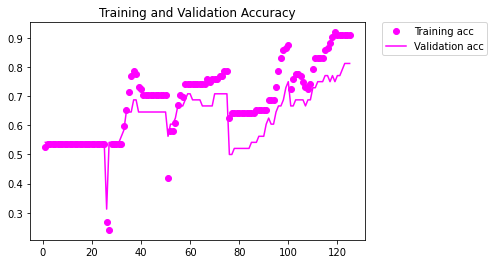

In [24]:
epochs_hybrid_multi = range(1, len(acc_hybrid_multi) + 1)

plt.plot(epochs_hybrid_multi, acc_hybrid_multi, 'o', color='magenta', label='Training acc')
plt.plot(epochs_hybrid_multi, val_acc_hybrid_multi, color='magenta', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

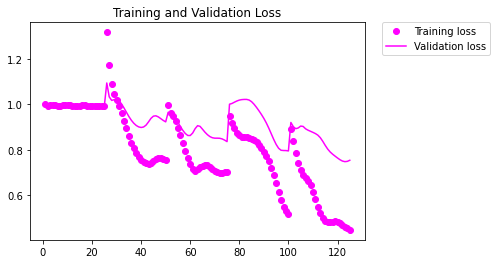

In [25]:
plt.plot(epochs_hybrid_multi, loss_hybrid_multi, 'o', color='magenta', label='Training loss')
plt.plot(epochs_hybrid_multi, val_loss_hybrid_multi, color='magenta', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

# QCNN w/ Layerwise Learning Model

## Phase I
Now we will set up our training loop. We specify the number of qubits in the circuit, how many layer addition steps to perform, and how many layers to add in each step. The latter is a hyperparameter of our model that can be tuned for the learning task at hand. There is a trade-off between keeping the trained partitions as small as possible, but at the same time not too small to make significant progress on the learning task. You can play with the hyperparameters below to notice this difference. We are not going to freeze the previous layers in phase one in this implementation, but simply grow the circuit incrementally.

In [26]:
n_qubits = 8
n_layer_steps = 5
n_layers_to_add = 2


# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, n_qubits)
readout_operators = cirq.Z(cluster_state_bits[-1])

symbols = []
layers = []
symbol_layers = []
weights = []

training_history = []
acc_phase_1 = []
val_acc_phase_1 = []
loss_phase_1 = []
val_loss_phase_1 = []

# Generate some training data.
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)

# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    #remove dimensions of size 1 from the shape of the tensor
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

for layer_id in range(n_layer_steps):
  print("\nLayer:", layer_id)
  #Create sequence of alternating convolution and pooling operators which gradually shrink over time.
  circuit = cirq.Circuit()
  for i in range(n_layers_to_add):
    layer, symbol_layer, layer_symbols = create_layer(cluster_state_bits, f'layer_{layer_id}_{i}')
    layers.append(layer)
    symbol_layers.append(symbol_layer)
    symbols.append(layer_symbols)
    
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    circuit += quantum_conv_circuit(cluster_state_bits)
    circuit += quantum_pool_circuit(cluster_state_bits[:4], cluster_state_bits[4:])
    circuit += quantum_conv_circuit(cluster_state_bits[4:])
    circuit += quantum_pool_circuit(cluster_state_bits[4:6], cluster_state_bits[6:])
    circuit += quantum_conv_circuit(cluster_state_bits[6:])
    circuit += quantum_pool_circuit([cluster_state_bits[6]], [cluster_state_bits[7]])
      
  circuit += symbol_layers

  # setup the Keras model
  qcnn_ll_model = tf.keras.Sequential()
  qcnn_ll_model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
  qcnn_ll_model.add(tfq.layers.PQC(
      model_circuit = circuit,
      operators=readout_operators,
      differentiator=tfq.differentiators.ParameterShift(),
      initializer=tf.keras.initializers.Zeros))

  print(qcnn_ll_model.summary())
  #Uses Squared Hinge max margin cost function to penalize misclassification and 
  #classify those correct ones residing within margin of the decision boundary
  qcnn_ll_model.compile(loss=tf.keras.losses.squared_hinge,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), 
                metrics=[custom_accuracy])

  # set parameters to 0 for new layers
  qcnn_ll_model.set_weights([np.pad(weights, (0, n_qubits*n_layers_to_add))])

  qcnn_ll_model_1_history = qcnn_ll_model.fit(
      x=train_excitations,
      y=train_labels,
      batch_size=128,
      epochs=25,
      verbose=1,
      validation_data=(test_excitations, test_labels))
  
  acc_phase_1 += qcnn_ll_model_1_history.history['custom_accuracy']
  val_acc_phase_1 += qcnn_ll_model_1_history.history['val_custom_accuracy']
  loss_phase_1 += qcnn_ll_model_1_history.history['loss']
  val_loss_phase_1 += qcnn_ll_model_1_history.history['val_loss']


  weights = qcnn_ll_model.get_weights()[0]


Layer: 0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_20 (PQC)                (None, 1)                 16        
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
1/1 [==============================] - 11s 11s/step - loss: 1.1771 - custom_accuracy: 0.7321 - val_loss: 1.0568 - val_custom_accuracy: 0.7708
Epoch 2/25
1/1 [==============================] - 10s 10s/step - loss: 1.1771 - custom_accuracy: 0.7321 - val_loss: 1.0567 - val_custom_accuracy: 0.7708
Epoch 3/25
1/1 [==============================] - 10s 10s/step - loss: 1.1770 - custom_accuracy: 0.7321 - val_loss: 1.0564 - val_custom_accuracy: 0.7708
Epoch 4/25
1/1 [==============================] - 10s 10s/step - loss: 1.1766 - custom_accuracy: 0.7321 - val_loss

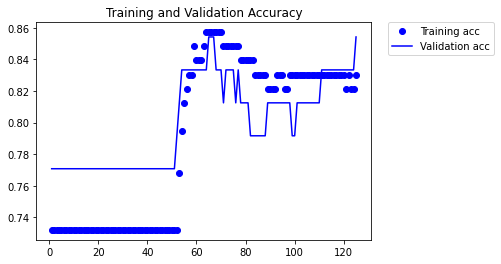

In [27]:
epochs_phase_1 = range(1, len(acc_phase_1) + 1)

plt.plot(epochs_phase_1, acc_phase_1, 'o', color='blue', label='Training acc')
plt.plot(epochs_phase_1, val_acc_phase_1, color='blue', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

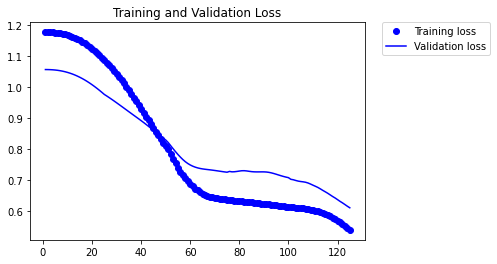

In [28]:
plt.plot(epochs_phase_1, loss_phase_1, 'o', color='blue', label='Training loss')
plt.plot(epochs_phase_1, val_loss_phase_1, color='blue', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

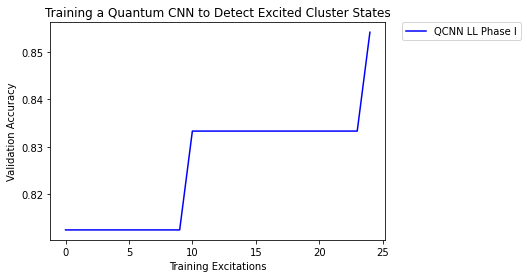

In [29]:
plt.plot(qcnn_ll_model_1_history.history['val_custom_accuracy'], color="blue", label='QCNN LL Phase I')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Training Excitations')
plt.ylabel('Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Phase II
After our circuit has grown to the specified size, we now use this as a starting point to train larger partitions. This means that we will split the circuit by specifiying a percentage of layers that should be trained as one contiguous set. In the example below, we will split the circuit in half, and then alternatingy train the two halfs for n_sweeps times.

To do this with TFQ, we need to keep track of the symbols associated with each gate, and only include the symbols of gates in the circuit configuration which we actually want to train.

In [30]:
partition_percentage = 0.5
partition_size = int(n_layer_steps*n_layers_to_add*partition_percentage)
n_partition_weights = partition_size*n_qubits
n_sweeps = 2
n_partitions = 2
readout = cirq.GridQubit(0, n_qubits-1)
sweep_count = 0
partition_count = 0

acc_phase_2 = []
val_acc_phase_2 = []
loss_phase_2 = []
val_loss_phase_2 = []

print("\nSweep over partitions\n")
for sweep in range(n_sweeps):
  sweep_count += 1
  partition_count = 0
  for partition in range(n_partitions):
    partition_count += 1
    # configure and train partitions
    print(f"Sweep {sweep_count}, Partition {partition_count}\n")

    trained_weights = weights[:n_partition_weights]
    untrained_weights = list(copy.copy(weights[n_partition_weights:][::-1]))
    untrained_layers = layers[partition_size:]

    trained_circuit = cirq.Circuit()
    trained_circuit += symbol_layers[:partition_size]
    trained_circuit += untrained_layers
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    trained_circuit += quantum_conv_circuit(cluster_state_bits)
    trained_circuit += quantum_pool_circuit(cluster_state_bits[:4], cluster_state_bits[4:])
    trained_circuit += quantum_conv_circuit(cluster_state_bits[4:])
    trained_circuit += quantum_pool_circuit(cluster_state_bits[4:6], cluster_state_bits[6:])
    trained_circuit += quantum_conv_circuit(cluster_state_bits[6:])
    trained_circuit += quantum_pool_circuit([cluster_state_bits[6]], [cluster_state_bits[7]])
    
    qcnn_ll_model = tf.keras.Sequential()
    qcnn_ll_model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
    qcnn_ll_model.add(
        tfq.layers.PQC(
            model_circuit=trained_circuit,
            operators=readout_operators,
            differentiator=tfq.differentiators.ParameterShift(),
            initializer=tf.keras.initializers.Zeros))

    qcnn_ll_model.compile(loss=tf.keras.losses.squared_hinge,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), 
                  metrics=[custom_accuracy])

    print(qcnn_ll_model.summary())

    qcnn_ll_model.set_weights([trained_weights])
    qcnn_ll_model_2_history = qcnn_ll_model.fit(
        x=train_excitations,
        y=train_labels,
        batch_size=128,
        epochs=25,
        verbose=1,
        validation_data=(test_excitations, test_labels))

    part_weights = qcnn_ll_model.get_weights()[0]

    acc_phase_2 += qcnn_ll_model_2_history.history['custom_accuracy']
    val_acc_phase_2 += qcnn_ll_model_2_history.history['val_custom_accuracy']
    loss_phase_2 += qcnn_ll_model_2_history.history['loss']
    val_loss_phase_2 += qcnn_ll_model_2_history.history['val_loss']

    weights[:n_partition_weights] = part_weights


Sweep over partitions

Sweep 1, Partition 1

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_25 (PQC)                (None, 1)                 40        
                                                                 
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
1/1 [==============================] - 28s 28s/step - loss: 0.8610 - custom_accuracy: 0.7946 - val_loss: 0.8442 - val_custom_accuracy: 0.8125
Epoch 2/25
1/1 [==============================] - 24s 24s/step - loss: 0.8047 - custom_accuracy: 0.8393 - val_loss: 0.7851 - val_custom_accuracy: 0.8542
Epoch 3/25
1/1 [==============================] - 23s 23s/step - loss: 0.7530 - custom_accuracy: 0.8571 - val_loss: 0.7329 - val_custom_accuracy: 0.8750
Epoch 4/25
1/1 [==============================] - 23s 23s/step - loss: 0.706

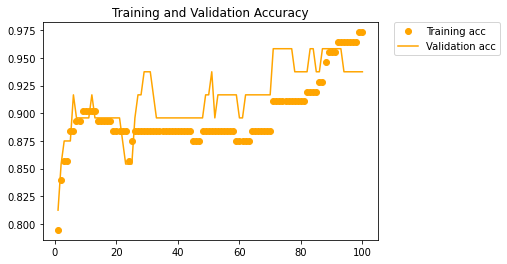

In [31]:
epochs_phase_2 = range(1, len(acc_phase_2) + 1)

plt.plot(epochs_phase_2, acc_phase_2, 'o', color='orange', label='Training acc')
plt.plot(epochs_phase_2, val_acc_phase_2, color='orange', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

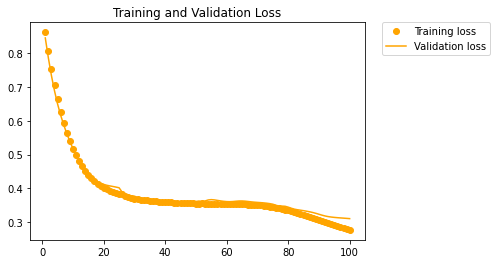

In [32]:
plt.plot(epochs_phase_2, loss_phase_2, 'o', color='orange', label='Training loss')
plt.plot(epochs_phase_2, val_loss_phase_2, color='orange', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

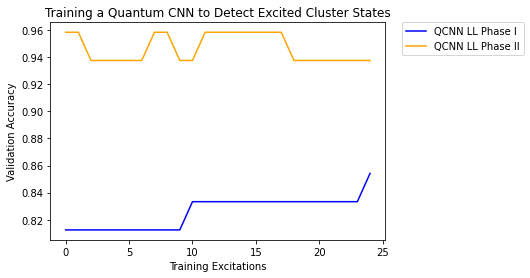

In [33]:
plt.plot(qcnn_ll_model_1_history.history['val_custom_accuracy'], color='blue', label='QCNN LL Phase I')
plt.plot(qcnn_ll_model_2_history.history['val_custom_accuracy'], color='orange', label='QCNN LL Phase II')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Training Excitations')
plt.ylabel('Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Phase III
Make final adjustments to partition %s and sweeps.

In [34]:
partition_percentage = 0.25
partition_size = int(n_layer_steps*n_layers_to_add*partition_percentage)
n_partition_weights = partition_size*n_qubits
n_sweeps = 4
sweep_count = 0
partition_count = 0

acc_phase_3 = []
val_acc_phase_3 = []
loss_phase_3 = []
val_loss_phase_3 = []

print("\nSweep over partitions\n")
for sweep in range(n_sweeps):
  sweep_count += 1
  partition_count = 0
  for partition in range(n_partitions):
    partition_count += 1
    # configure and train partitions
    print(f"Sweep {sweep_count}, Partition {partition_count}\n")

    trained_weights = weights[:n_partition_weights]
    untrained_weights = list(copy.copy(weights[n_partition_weights:][::-1]))
    untrained_layers = layers[partition_size:]

    trained_circuit = cirq.Circuit()
    trained_circuit += symbol_layers[:partition_size]
    trained_circuit += untrained_layers
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    trained_circuit += quantum_conv_circuit(cluster_state_bits)
    trained_circuit += quantum_pool_circuit(cluster_state_bits[:4], cluster_state_bits[4:])
    trained_circuit += quantum_conv_circuit(cluster_state_bits[4:])
    trained_circuit += quantum_pool_circuit(cluster_state_bits[4:6], cluster_state_bits[6:])
    trained_circuit += quantum_conv_circuit(cluster_state_bits[6:])
    trained_circuit += quantum_pool_circuit([cluster_state_bits[6]], [cluster_state_bits[7]])
    
    qcnn_ll_model = tf.keras.Sequential()
    qcnn_ll_model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
    qcnn_ll_model.add(
        tfq.layers.PQC(
            model_circuit=trained_circuit,
            operators=readout_operators,
            differentiator=tfq.differentiators.ParameterShift(),
            initializer=tf.keras.initializers.Zeros))

    qcnn_ll_model.compile(loss=tf.keras.losses.squared_hinge,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), 
                  metrics=[custom_accuracy])

    print(qcnn_ll_model.summary())

    qcnn_ll_model.set_weights([trained_weights])
    qcnn_ll_model_3_history = qcnn_ll_model.fit(
        x=train_excitations,
        y=train_labels,
        batch_size=128,
        epochs=25,
        verbose=1,
        validation_data=(test_excitations, test_labels))

    part_weights = qcnn_ll_model.get_weights()[0]

    acc_phase_3 += qcnn_ll_model_3_history.history['custom_accuracy']
    val_acc_phase_3 += qcnn_ll_model_3_history.history['val_custom_accuracy']
    loss_phase_3 += qcnn_ll_model_3_history.history['loss']
    val_loss_phase_3 += qcnn_ll_model_3_history.history['val_loss']

    weights[:n_partition_weights] = part_weights


Sweep over partitions

Sweep 1, Partition 1

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_29 (PQC)                (None, 1)                 16        
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
1/1 [==============================] - 8s 8s/step - loss: 0.7324 - custom_accuracy: 0.9643 - val_loss: 0.7520 - val_custom_accuracy: 0.9583
Epoch 2/25
1/1 [==============================] - 7s 7s/step - loss: 0.7133 - custom_accuracy: 0.9643 - val_loss: 0.7338 - val_custom_accuracy: 0.9583
Epoch 3/25
1/1 [==============================] - 7s 7s/step - loss: 0.6945 - custom_accuracy: 0.9732 - val_loss: 0.7159 - val_custom_accuracy: 0.9583
Epoch 4/25
1/1 [==============================] - 7s 7s/step - loss: 0.6756 - cust

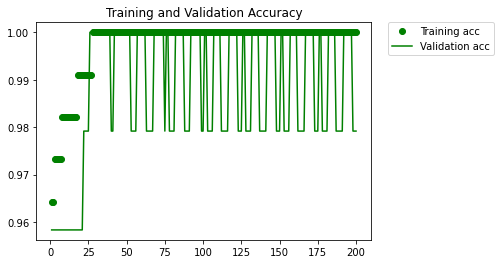

In [35]:
epochs_phase_3 = range(1, len(acc_phase_3) + 1)

plt.plot(epochs_phase_3, acc_phase_3, 'o', color='green', label='Training acc')
plt.plot(epochs_phase_3, val_acc_phase_3, color='green', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

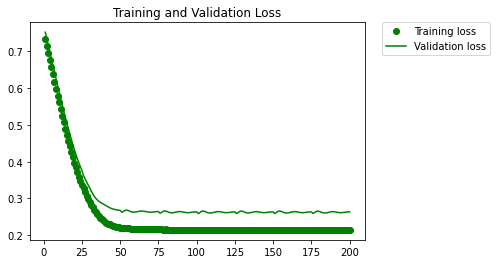

In [36]:
plt.plot(epochs_phase_3, loss_phase_3, 'o', color='green', label='Training loss')
plt.plot(epochs_phase_3, val_loss_phase_3, color='green', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

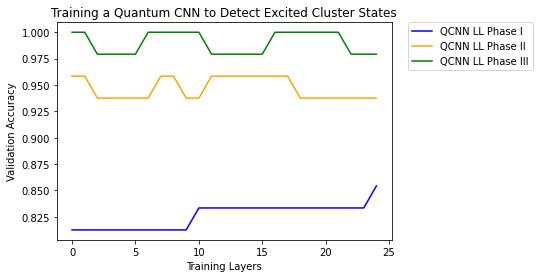

In [37]:
plt.plot(qcnn_ll_model_1_history.history['val_custom_accuracy'], color='blue', label='QCNN LL Phase I')
plt.plot(qcnn_ll_model_2_history.history['val_custom_accuracy'], color='orange', label='QCNN LL Phase II')
plt.plot(qcnn_ll_model_3_history.history['val_custom_accuracy'], color='green', label='QCNN LL Phase III')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Training Layers')
plt.ylabel('Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

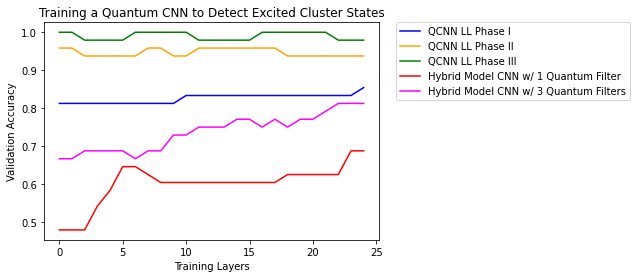

In [38]:
plt.plot(qcnn_ll_model_1_history.history['val_custom_accuracy'], color='blue', label='QCNN LL Phase I')
plt.plot(qcnn_ll_model_2_history.history['val_custom_accuracy'], color='orange', label='QCNN LL Phase II')
plt.plot(qcnn_ll_model_3_history.history['val_custom_accuracy'], color='green', label='QCNN LL Phase III')
plt.plot(hybrid_model_history.history['val_custom_accuracy'], color='red', label='Hybrid Model CNN w/ 1 Quantum Filter')
plt.plot(multi_qcnn_model_history.history['val_custom_accuracy'], color='magenta', label='Hybrid Model CNN w/ 3 Quantum Filters')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Training Layers')
plt.ylabel('Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

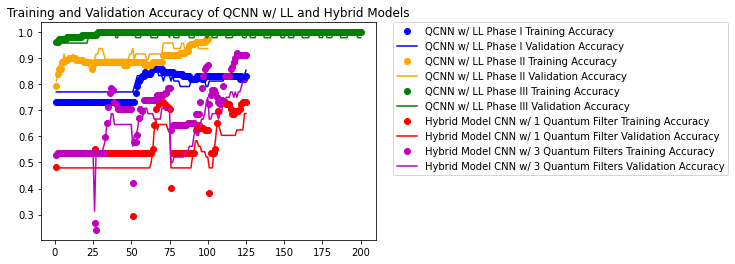

In [39]:
plt.plot(epochs_phase_1, acc_phase_1, 'bo', label='QCNN w/ LL Phase I Training Accuracy')
plt.plot(epochs_phase_1, val_acc_phase_1, 'b', label='QCNN w/ LL Phase I Validation Accuracy')
plt.plot(epochs_phase_2, acc_phase_2, 'o', color='orange', label='QCNN w/ LL Phase II Training Accuracy')
plt.plot(epochs_phase_2, val_acc_phase_2, color='orange', label='QCNN w/ LL Phase II Validation Accuracy')
plt.plot(epochs_phase_3, acc_phase_3, 'go', label='QCNN w/ LL Phase III Training Accuracy')
plt.plot(epochs_phase_3, val_acc_phase_3, 'g', label='QCNN w/ LL Phase III Validation Accuracy')
plt.plot(epochs_hybrid, acc_hybrid, 'ro', label='Hybrid Model CNN w/ 1 Quantum Filter Training Accuracy')
plt.plot(epochs_hybrid, val_acc_hybrid, 'r', label='Hybrid Model CNN w/ 1 Quantum Filter Validation Accuracy')
plt.plot(epochs_hybrid_multi, acc_hybrid_multi, 'mo', label='Hybrid Model CNN w/ 3 Quantum Filters Training Accuracy')
plt.plot(epochs_hybrid_multi, val_acc_hybrid_multi, 'm', label='Hybrid Model CNN w/ 3 Quantum Filters Validation Accuracy')
plt.title('Training and Validation Accuracy of QCNN w/ LL and Hybrid Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

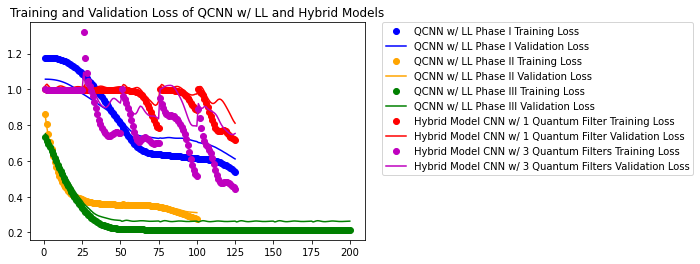

In [40]:
plt.plot(epochs_phase_1, loss_phase_1, 'bo', label='QCNN w/ LL Phase I Training Loss')
plt.plot(epochs_phase_1, val_loss_phase_1, 'b', label='QCNN w/ LL Phase I Validation Loss')
plt.plot(epochs_phase_2, loss_phase_2, 'o', color='orange', label='QCNN w/ LL Phase II Training Loss')
plt.plot(epochs_phase_2, val_loss_phase_2, color='orange', label='QCNN w/ LL Phase II Validation Loss')
plt.plot(epochs_phase_3, loss_phase_3, 'go', label='QCNN w/ LL Phase III Training Loss')
plt.plot(epochs_phase_3, val_loss_phase_3, 'g', label='QCNN w/ LL Phase III Validation Loss')
plt.plot(epochs_hybrid, loss_hybrid, 'ro', label='Hybrid Model CNN w/ 1 Quantum Filter Training Loss')
plt.plot(epochs_hybrid, val_loss_hybrid, 'r', label='Hybrid Model CNN w/ 1 Quantum Filter Validation Loss')
plt.plot(epochs_hybrid_multi, loss_hybrid_multi, 'mo', label='Hybrid Model CNN w/ 3 Quantum Filters Training Loss')
plt.plot(epochs_hybrid_multi, val_loss_hybrid_multi, 'm', label='Hybrid Model CNN w/ 3 Quantum Filters Validation Loss')
plt.title('Training and Validation Loss of QCNN w/ LL and Hybrid Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()